# Multi-Class Model for [PROJECT NAME] Using TensorFlow Decision Forests version 1
### David Lowe
### November 25, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The [PROJECT NAME] dataset is a multi-class modeling situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: [Sample Paragraph: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions on Kaggle with fun but less complex, tabular datasets. The dataset used for this competition is synthetic but based on a real dataset and generated using a CTGAN. The original dataset deals with predicting the category on an eCommerce product given various attributes about the listing. Although the features are anonymized, they have properties relating to real-world features.]

ANALYSIS: [Sample Paragraph: The performance of the preliminary Gradient Boosted Trees model achieved a logarithmic loss benchmark of 1.6147 on the validation dataset. The final model processed the validation dataset with a final logarithmic loss score of 1.2918. When we applied the finalized model to Kaggle's test dataset, the model achieved a logarithmic loss score of 2.1399]

CONCLUSION: In this iteration, the TensorFlow Decision Forests model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: [PROJECT NAME] Dataset

Dataset ML Model: Multi-Class with [numerical | categorical] attributes

Dataset Reference: [Sample URL: https://www.kaggle.com/c/tabular-playground-series-may-2021]

One potential source of performance benchmarks: [Sample URL: https://www.kaggle.com/c/tabular-playground-series-may-2021/leaderboard]

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Train and Evaluate Models
4. Fine-tune and Improve Models
5. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Installing TFDF might be necessary when using the script with Google Colab
# !pip install tensorflow_decision_forests

In [3]:
# For managing screen output when using the script with Google Colab
# !pip install wurlitzer

In [4]:
# # Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [5]:
# # Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [6]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


### 1.a) Load libraries and modules

In [7]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [8]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
from sklearn import metrics
import tensorflow as tf
tf.random.set_seed(RNG_SEED)
# from tensorflow import keras
import tensorflow_decision_forests as tfdf

2021-11-24 00:25:02.431510: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-24 00:25:02.431568: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [9]:
# For managing screen output and model plotting when using the script with Google Colab

# try:
#   from wurlitzer import sys_pipes
# except:
#   from colabtools.googlelog import CaptureLog as sys_pipes

# from IPython.core.magic import register_line_magic
# from IPython.display import Javascript

### 1.b) Set up the controlling parameters and functions

In [10]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.2

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_METRICS = ["accuracy", tf.keras.metrics.SparseCategoricalCrossentropy()]

# Define the directory locations and file names
TRAIN_DATASET = 'train.csv'
TEST_DATASET = 'test.csv'

# # Check the number of GPUs accessible through TensorFlow
# print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow version: 2.7.0
Found TensorFlow Decision Forests v0.2.1


2021-11-24 00:25:04.703595: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-24 00:25:04.703644: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-24 00:25:04.703681: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (20d838f3f8d1): /proc/driver/nvidia/version does not exist


In [11]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [12]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [13]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [14]:
if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021may/train.csv

In [15]:
df_dataset_import = pd.read_csv(TRAIN_DATASET, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id  feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0          0          0          1          0          1          0   
1   1          0          0          0          0          2          1   
2   2          0          0          0          0          0          0   
3   3          0          0          0          0          0          0   
4   4          0          0          0          0          0          0   

   feature_6  feature_7  feature_8  ...  feature_41  feature_42  feature_43  \
0          0          0          0  ...           0           0          21   
1          0          0          0  ...           0           0           0   
2          0          0          0  ...           0           1           0   
3          0          3          0  ...           0           0           0   
4          0          0          0  ...           0           0           0   

   feature_44  feature_45  feature_46  feature_47  feature_48  feature_49 

In [16]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 52 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          100000 non-null  int64 
 1   feature_0   100000 non-null  int64 
 2   feature_1   100000 non-null  int64 
 3   feature_2   100000 non-null  int64 
 4   feature_3   100000 non-null  int64 
 5   feature_4   100000 non-null  int64 
 6   feature_5   100000 non-null  int64 
 7   feature_6   100000 non-null  int64 
 8   feature_7   100000 non-null  int64 
 9   feature_8   100000 non-null  int64 
 10  feature_9   100000 non-null  int64 
 11  feature_10  100000 non-null  int64 
 12  feature_11  100000 non-null  int64 
 13  feature_12  100000 non-null  int64 
 14  feature_13  100000 non-null  int64 
 15  feature_14  100000 non-null  int64 
 16  feature_15  100000 non-null  int64 
 17  feature_16  100000 non-null  int64 
 18  feature_17  100000 non-null  int64 
 19  feature_18  100000 non-n

In [17]:
print(df_dataset_import.describe())

                  id      feature_0      feature_1      feature_2  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean    49999.500000       0.257830       0.431720       0.114130   
std     28867.657797       0.929033       1.977862       0.519584   
min         0.000000       0.000000       0.000000       0.000000   
25%     24999.750000       0.000000       0.000000       0.000000   
50%     49999.500000       0.000000       0.000000       0.000000   
75%     74999.250000       0.000000       0.000000       0.000000   
max     99999.000000      10.000000      31.000000       6.000000   

           feature_3      feature_4      feature_5      feature_6  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.590550       0.599770       0.160820       0.731490   
std         1.844558       2.785531       0.601149       2.343465   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.0000

In [18]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id            0
feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
feature_16    0
feature_17    0
feature_18    0
feature_19    0
feature_20    0
feature_21    0
feature_22    0
feature_23    0
feature_24    0
feature_25    0
feature_26    0
feature_27    0
feature_28    0
feature_29    0
feature_30    0
feature_31    0
feature_32    0
feature_33    0
feature_34    0
feature_35    0
feature_36    0
feature_37    0
feature_38    0
feature_39    0
feature_40    0
feature_41    0
feature_42    0
feature_43    0
feature_44    0
feature_45    0
feature_46    0
feature_47    0
feature_48    0
feature_49    0
target        0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [19]:
# Dropping features
df_dataset_import.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0          0          0          1          0          1          0   
1          0          0          0          0          2          1   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   feature_6  feature_7  feature_8  feature_9  ...  feature_41  feature_42  \
0          0          0          0          0  ...           0           0   
1          0          0          0          0  ...           0           0   
2          0          0          0          2  ...           0           1   
3          0          3          0          0  ...           0           0   
4          0          0          0          0  ...           0           0   

   feature_43  feature_44  feature_45  feature_46  feature_47  feature_48  \
0          21           0  

In [20]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 51 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   feature_0   100000 non-null  int64 
 1   feature_1   100000 non-null  int64 
 2   feature_2   100000 non-null  int64 
 3   feature_3   100000 non-null  int64 
 4   feature_4   100000 non-null  int64 
 5   feature_5   100000 non-null  int64 
 6   feature_6   100000 non-null  int64 
 7   feature_7   100000 non-null  int64 
 8   feature_8   100000 non-null  int64 
 9   feature_9   100000 non-null  int64 
 10  feature_10  100000 non-null  int64 
 11  feature_11  100000 non-null  int64 
 12  feature_12  100000 non-null  int64 
 13  feature_13  100000 non-null  int64 
 14  feature_14  100000 non-null  int64 
 15  feature_15  100000 non-null  int64 
 16  feature_16  100000 non-null  int64 
 17  feature_17  100000 non-null  int64 
 18  feature_18  100000 non-null  int64 
 19  feature_19  100000 non-n

In [21]:
print(df_dataset_import.describe())

           feature_0      feature_1      feature_2      feature_3  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.257830       0.431720       0.114130       0.590550   
std         0.929033       1.977862       0.519584       1.844558   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max        10.000000      31.000000       6.000000      26.000000   

           feature_4      feature_5      feature_6      feature_7  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.599770       0.160820       0.731490       1.228920   
std         2.785531       0.601149       2.343465       2.692732   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.0000

In [22]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
feature_16    0
feature_17    0
feature_18    0
feature_19    0
feature_20    0
feature_21    0
feature_22    0
feature_23    0
feature_24    0
feature_25    0
feature_26    0
feature_27    0
feature_28    0
feature_29    0
feature_30    0
feature_31    0
feature_32    0
feature_33    0
feature_34    0
feature_35    0
feature_36    0
feature_37    0
feature_38    0
feature_39    0
feature_40    0
feature_41    0
feature_42    0
feature_43    0
feature_44    0
feature_45    0
feature_46    0
feature_47    0
feature_48    0
feature_49    0
target        0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Sets

In [23]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (100000, 51) df_features_train.shape: (100000, 50) df_target_train.shape: (100000,)


### 1.f) Set up the parameters for data visualization

In [24]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [25]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [26]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

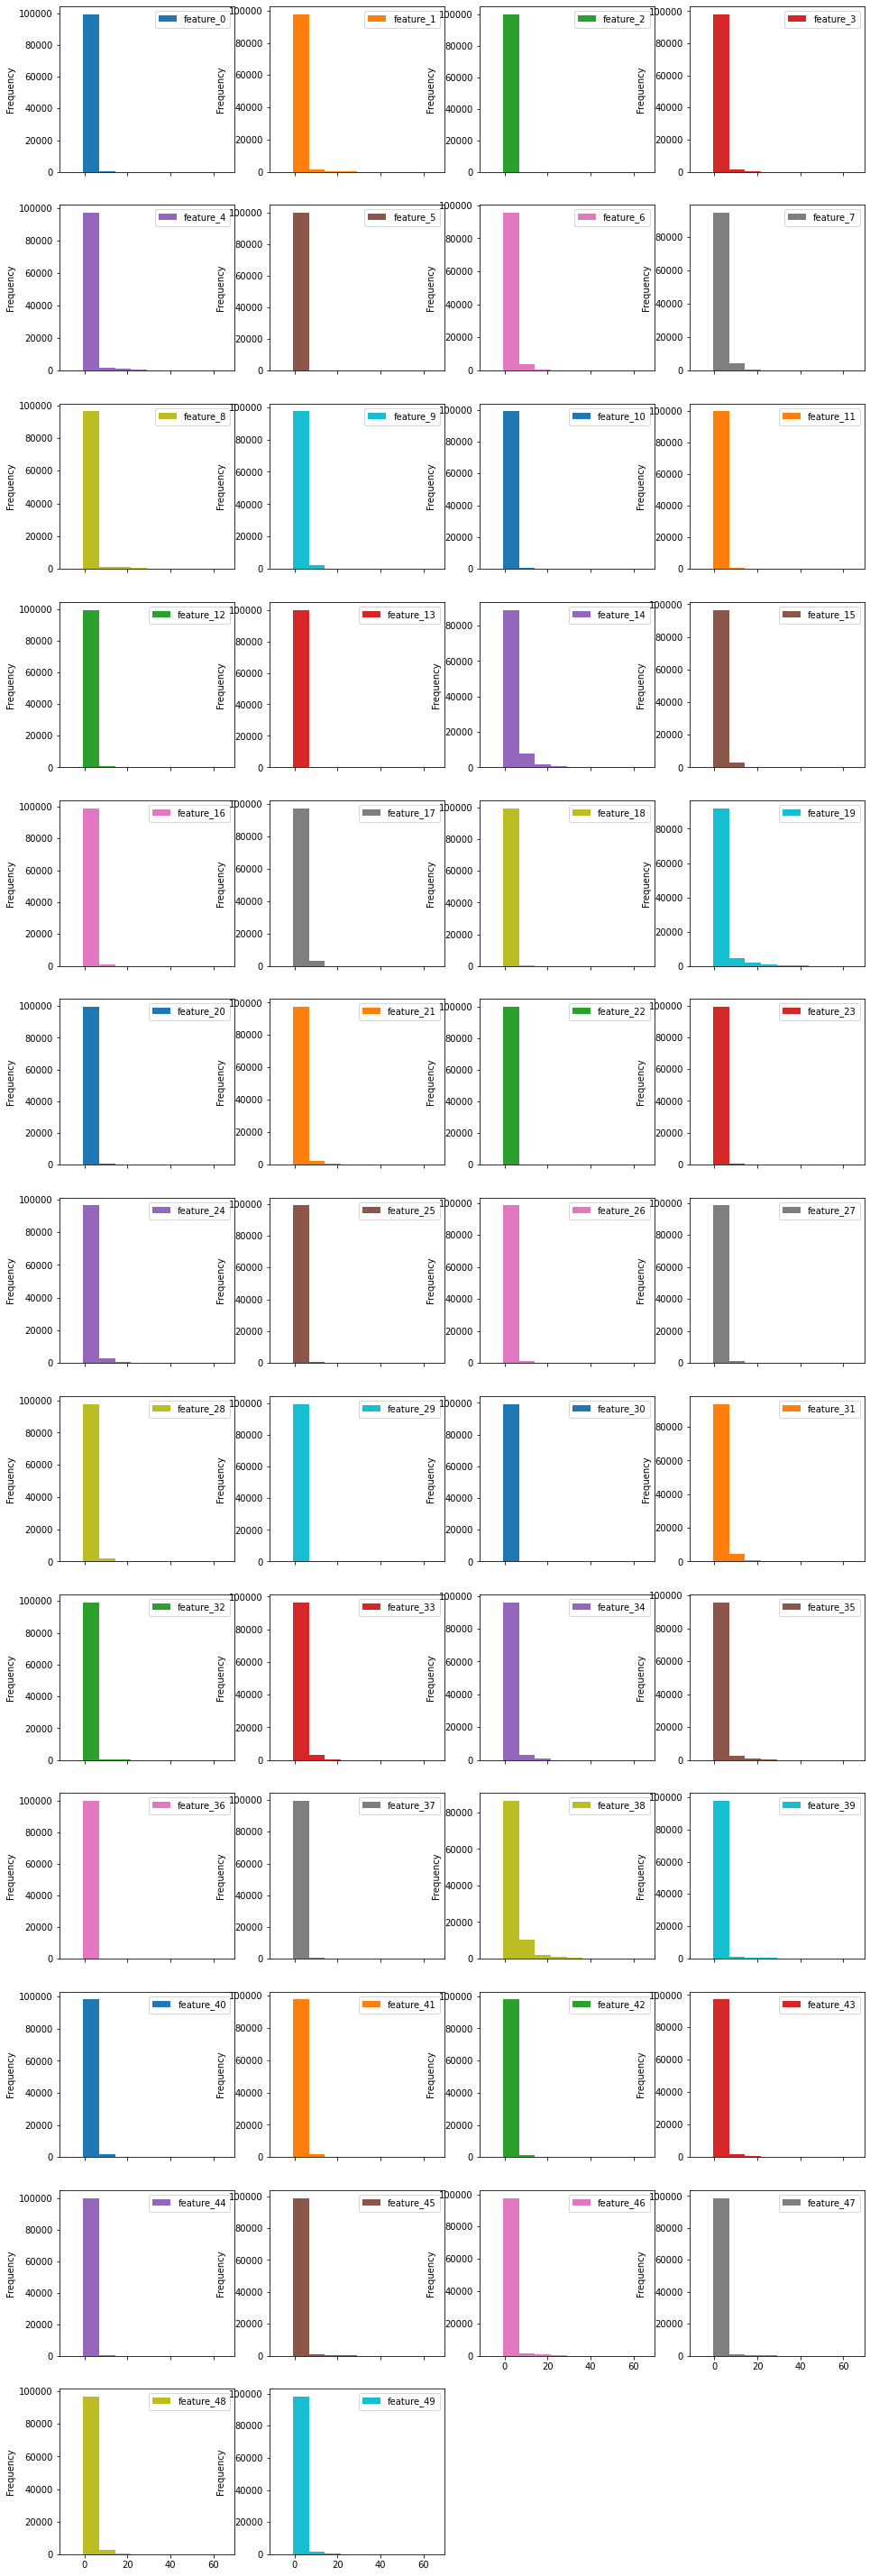

In [27]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

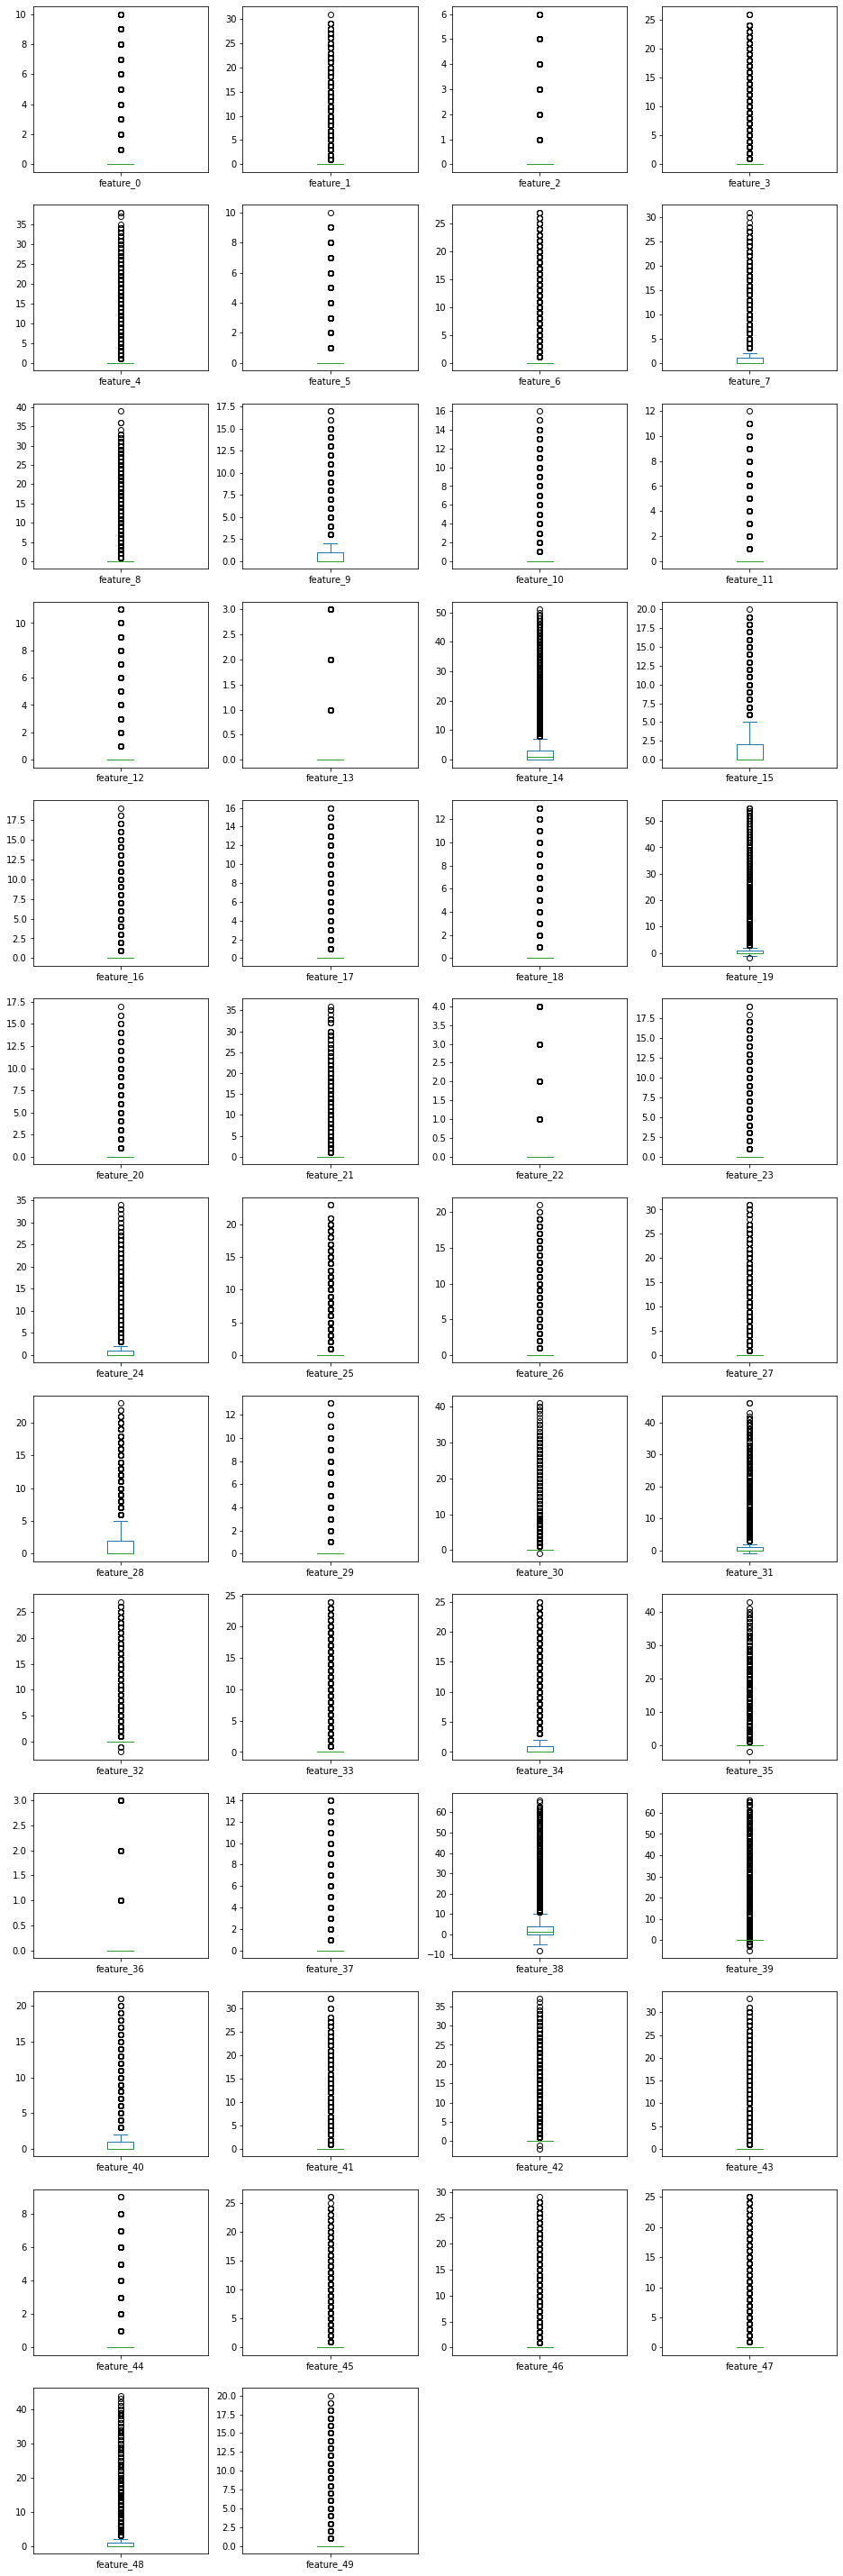

In [28]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

In [29]:
# Correlation matrix
# fig = plt.figure(figsize=(20, 20))
# correlations = df_features_train.corr(method='pearson')
# sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
# plt.show()

In [30]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Train and Evaluate Models

In [31]:
if NOTIFY_STATUS: status_notify("Task 3 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Validation Sets

In [32]:
# Split the data further into training and validation datasets
df_dataset_train, df_dataset_valid = train_test_split(df_dataset_import, test_size=VAL_SET_RATIO, random_state=RNG_SEED)
print("df_dataset_train.shape: {} df_dataset_valid.shape: {}".format(df_dataset_train.shape, df_dataset_valid.shape))

df_dataset_train.shape: (80000, 51) df_dataset_valid.shape: (20000, 51)


In [33]:
# Finalize the training and validation datasets for the modeling activities
tfds_train = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_train, label='target', task = tfdf.keras.Task.CLASSIFICATION)
tfds_valid = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_valid, label='target', task = tfdf.keras.Task.CLASSIFICATION)

/home/pythonml/appdev/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:1612: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


### 3.b) Train and Evaluate the Random Forest Model

In [34]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
RF_model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.CLASSIFICATION)
RF_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     RF_model.fit(x=tfds_train)

# Train the model.
RF_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

1245/1250 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 1250
[INFO kernel.cc:393] Number of examples: 80000
[INFO kernel.cc:759] Dataset:
Number of records: 80000
Number of columns: 51

Number of columns by type:
	NUMERICAL: 50 (98.0392%)
	CATEGORICAL: 1 (1.96078%)

Columns:

NUMERICAL: 50 (98.0392%)
	0: "feature_0" NUMERICAL mean:0.257812 min:0 max:10 sd:0.928262
	1: "feature_1" NUMERICAL mean:0.42845 min:0 max:31 sd:1.96312
	2: "feature_10" NUMERICAL mean:0.312837 min:0 max:15 sd:1.12395
	3: "feature_11" NUMERICAL mean:0.405763 min:0 max:12 sd:1.01642
	4: "feature_12" NUMERICAL mean:0.460688 min:0 max:11 sd:1.12668
	5: "feature_13" NUMERICAL mean:0.0763125 min:0 max:3 sd:0.360644
	6: "feature_14" NUMERICAL mean:2.60879 min:0 max:51 sd:4.67293
	7: "feature_15" NUMERICAL mean:1.23971 min:0 max:19 sd:2.15601
	8: "feature_16" NUMERICAL mean:0.367287 min:0 max:18 sd:1.28267
	9: "feature_17" NUMERICAL mean:0

1250/1250 [==============================] - 48s 34ms/step


[INFO decision_forest.cc:590] Model loaded with 300 root(s), 952038 node(s), and 50 input feature(s).
[INFO abstract_model.cc:993] Engine "RandomForestGeneric" built
[INFO kernel.cc:848] Use fast generic engine


Model training time: 0:01:30.537995 



In [35]:
RF_eval = RF_model.evaluate(tfds_valid, return_dict=True)
print()

for name, value in RF_eval.items():
    print(f"{name}: {value:.4f}")

313/313 [==============================] - 3s 8ms/step - loss: 0.0000e+00 - accuracy: 0.5725 - sparse_categorical_crossentropy: 2.5587

loss: 0.0000
accuracy: 0.5725
sparse_categorical_crossentropy: 2.5587


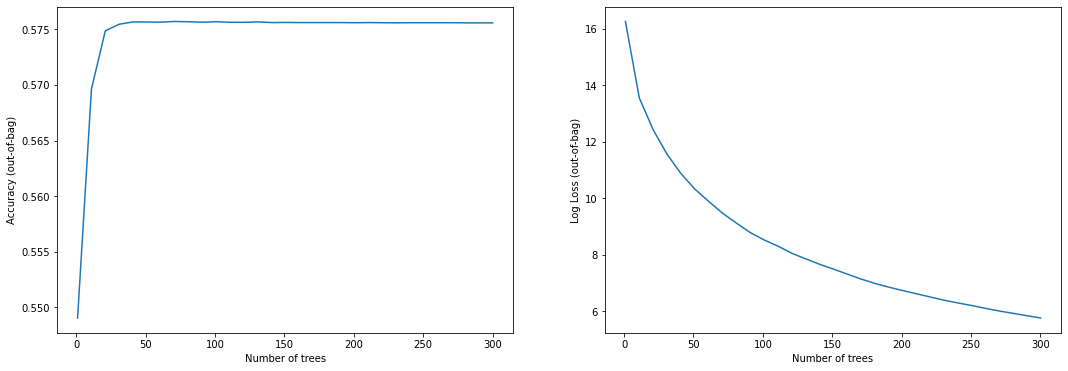

In [36]:
logs = RF_model.make_inspector().training_logs()

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Log Loss (out-of-bag)")
plt.show()

In [37]:
# Plot the model using Google Colab
# tfdf.model_plotter.plot_model_in_colab(RF_model)

### 3.c) Train and Evaluate the Decision Trees Model

In [38]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
CART_model = tfdf.keras.CartModel(task = tfdf.keras.Task.CLASSIFICATION)
CART_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     CART_model.fit(x=tfds_train)

# Train the model.
CART_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

1238/1250 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 1250
[INFO kernel.cc:393] Number of examples: 80000
[INFO kernel.cc:759] Dataset:
Number of records: 80000
Number of columns: 51

Number of columns by type:
	NUMERICAL: 50 (98.0392%)
	CATEGORICAL: 1 (1.96078%)

Columns:

NUMERICAL: 50 (98.0392%)
	0: "feature_0" NUMERICAL mean:0.257812 min:0 max:10 sd:0.928262
	1: "feature_1" NUMERICAL mean:0.42845 min:0 max:31 sd:1.96312
	2: "feature_10" NUMERICAL mean:0.312837 min:0 max:15 sd:1.12395
	3: "feature_11" NUMERICAL mean:0.405763 min:0 max:12 sd:1.01642
	4: "feature_12" NUMERICAL mean:0.460688 min:0 max:11 sd:1.12668
	5: "feature_13" NUMERICAL mean:0.0763125 min:0 max:3 sd:0.360644
	6: "feature_14" NUMERICAL mean:2.60879 min:0 max:51 sd:4.67293
	7: "feature_15" NUMERICAL mean:1.23971 min:0 max:19 sd:2.15601
	8: "feature_16" NUMERICAL mean:0.367287 min:0 max:18 sd:1.28267
	9: "feature_17" NUMERICAL mean:0

1250/1250 [==============================] - 7s 5ms/step


[INFO cart.cc:375] 3847 nodes before pruning. 475 nodes after pruning.
[INFO kernel.cc:828] Export model in log directory: /tmp/tmprlc88ebv
[INFO kernel.cc:836] Save model in resources
[INFO kernel.cc:988] Loading model from path
[INFO decision_forest.cc:590] Model loaded with 1 root(s), 475 node(s), and 50 input feature(s).
[INFO abstract_model.cc:993] Engine "RandomForestGeneric" built
[INFO kernel.cc:848] Use fast generic engine


Model training time: 0:00:07.616547 



In [39]:
CART_eval = CART_model.evaluate(tfds_valid, return_dict=True)
print()

for name, value in CART_eval.items():
    print(f"{name}: {value:.4f}")

313/313 [==============================] - 2s 5ms/step - loss: 0.0000e+00 - accuracy: 0.5684 - sparse_categorical_crossentropy: 1.8730

loss: 0.0000
accuracy: 0.5684
sparse_categorical_crossentropy: 1.8730


In [40]:
# Plot the model using Google Colab
# tfdf.model_plotter.plot_model_in_colab(CART_model)

### 3.d) Train and Evaluate the Gradient Boosted Trees Model

In [41]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
GBT_model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.CLASSIFICATION)
GBT_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     GBT_model.fit(x=tfds_train)

# Train the model.
GBT_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

1249/1250 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 1250
[INFO kernel.cc:393] Number of examples: 80000
[INFO kernel.cc:759] Dataset:
Number of records: 80000
Number of columns: 51

Number of columns by type:
	NUMERICAL: 50 (98.0392%)
	CATEGORICAL: 1 (1.96078%)

Columns:

NUMERICAL: 50 (98.0392%)
	0: "feature_0" NUMERICAL mean:0.257812 min:0 max:10 sd:0.928262
	1: "feature_1" NUMERICAL mean:0.42845 min:0 max:31 sd:1.96312
	2: "feature_10" NUMERICAL mean:0.312837 min:0 max:15 sd:1.12395
	3: "feature_11" NUMERICAL mean:0.405763 min:0 max:12 sd:1.01642
	4: "feature_12" NUMERICAL mean:0.460688 min:0 max:11 sd:1.12668
	5: "feature_13" NUMERICAL mean:0.0763125 min:0 max:3 sd:0.360644
	6: "feature_14" NUMERICAL mean:2.60879 min:0 max:51 sd:4.67293
	7: "feature_15" NUMERICAL mean:1.23971 min:0 max:19 sd:2.15601
	8: "feature_16" NUMERICAL mean:0.367287 min:0 max:18 sd:1.28267
	9: "feature_17" NUMERICAL mean:0

1250/1250 [==============================] - 58s 46ms/step


[INFO gradient_boosted_trees.cc:2740] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.09967
[INFO gradient_boosted_trees.cc:229] Truncates the model to 464 tree(s) i.e. 116  iteration(s).
[INFO gradient_boosted_trees.cc:263] Final model num-trees:116 valid-loss:1.099665 valid-accuracy:0.575169
[INFO kernel.cc:828] Export model in log directory: /tmp/tmpqb6nq7as
[INFO kernel.cc:836] Save model in resources
[INFO kernel.cc:988] Loading model from path
[INFO decision_forest.cc:590] Model loaded with 464 root(s), 22584 node(s), and 50 input feature(s).
[INFO abstract_model.cc:993] Engine "GradientBoostedTreesGeneric" built
[INFO kernel.cc:848] Use fast generic engine


Model training time: 0:01:22.899024 



In [42]:
GBT_eval = GBT_model.evaluate(tfds_valid, return_dict=True)
print()

for name, value in GBT_eval.items():
    print(f"{name}: {value:.4f}")

313/313 [==============================] - 2s 7ms/step - loss: 0.0000e+00 - accuracy: 0.5762 - sparse_categorical_crossentropy: 1.6147

loss: 0.0000
accuracy: 0.5762
sparse_categorical_crossentropy: 1.6147


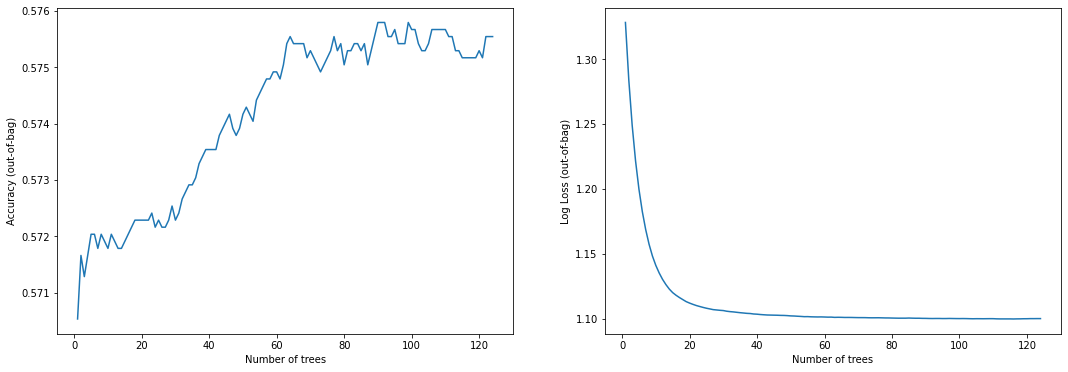

In [43]:
logs = GBT_model.make_inspector().training_logs()

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Log Loss (out-of-bag)")
plt.show()

In [44]:
# Plot the model using Google Colab
# tfdf.model_plotter.plot_model_in_colab(GBT_model)

In [45]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Fine-tune and Improve Models

In [46]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [47]:
for num_trees in [300, 500, 750, 1000]:
    # Define the baseline model for benchmarking
    start_time_module = datetime.now()
    reset_random()
    Tuning_model = tfdf.keras.GradientBoostedTreesModel(num_trees=num_trees, task = tfdf.keras.Task.CLASSIFICATION)

    # Optionally, add evaluation metrics.
    Tuning_model.compile(metrics=DEFAULT_METRICS)

    # Train the model.
    Tuning_model.fit(x=tfds_train)

    Tuning_eval = Tuning_model.evaluate(tfds_valid, return_dict=True)
    print()

    for name, value in Tuning_eval.items():
        print(f"{name}: {value:.4f}")
    print ('Model optimization time:', (datetime.now() - start_time_module), '\n')

1245/1250 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 1250
[INFO kernel.cc:393] Number of examples: 80000
[INFO kernel.cc:759] Dataset:
Number of records: 80000
Number of columns: 51

Number of columns by type:
	NUMERICAL: 50 (98.0392%)
	CATEGORICAL: 1 (1.96078%)

Columns:

NUMERICAL: 50 (98.0392%)
	0: "feature_0" NUMERICAL mean:0.257812 min:0 max:10 sd:0.928262
	1: "feature_1" NUMERICAL mean:0.42845 min:0 max:31 sd:1.96312
	2: "feature_10" NUMERICAL mean:0.312837 min:0 max:15 sd:1.12395
	3: "feature_11" NUMERICAL mean:0.405763 min:0 max:12 sd:1.01642
	4: "feature_12" NUMERICAL mean:0.460688 min:0 max:11 sd:1.12668
	5: "feature_13" NUMERICAL mean:0.0763125 min:0 max:3 sd:0.360644
	6: "feature_14" NUMERICAL mean:2.60879 min:0 max:51 sd:4.67293
	7: "feature_15" NUMERICAL mean:1.23971 min:0 max:19 sd:2.15601
	8: "feature_16" NUMERICAL mean:0.367287 min:0 max:18 sd:1.28267
	9: "feature_17" NUMERICAL mean:0

1250/1250 [==============================] - 59s 47ms/step


[INFO gradient_boosted_trees.cc:2740] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.09967
[INFO gradient_boosted_trees.cc:229] Truncates the model to 464 tree(s) i.e. 116  iteration(s).
[INFO gradient_boosted_trees.cc:263] Final model num-trees:116 valid-loss:1.099665 valid-accuracy:0.575169
[INFO kernel.cc:828] Export model in log directory: /tmp/tmpjwloe_3d
[INFO kernel.cc:836] Save model in resources
[INFO kernel.cc:988] Loading model from path
[INFO decision_forest.cc:590] Model loaded with 464 root(s), 22584 node(s), and 50 input feature(s).
[INFO abstract_model.cc:993] Engine "GradientBoostedTreesGeneric" built
[INFO kernel.cc:848] Use fast generic engine


313/313 [==============================] - 2s 7ms/step - loss: 0.0000e+00 - accuracy: 0.5762 - sparse_categorical_crossentropy: 1.4855

loss: 0.0000
accuracy: 0.5762
sparse_categorical_crossentropy: 1.4855
Model optimization time: 0:01:25.327537 

1243/1250 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 1250
[INFO kernel.cc:393] Number of examples: 80000
[INFO kernel.cc:759] Dataset:
Number of records: 80000
Number of columns: 51

Number of columns by type:
	NUMERICAL: 50 (98.0392%)
	CATEGORICAL: 1 (1.96078%)

Columns:

NUMERICAL: 50 (98.0392%)
	0: "feature_0" NUMERICAL mean:0.257812 min:0 max:10 sd:0.928262
	1: "feature_1" NUMERICAL mean:0.42845 min:0 max:31 sd:1.96312
	2: "feature_10" NUMERICAL mean:0.312837 min:0 max:15 sd:1.12395
	3: "feature_11" NUMERICAL mean:0.405763 min:0 max:12 sd:1.01642
	4: "feature_12" NUMERICAL mean:0.460688 min:0 max:11 sd:1.12668
	5: "feature_13" NUMERICAL mean:0.0763125 min:0 max:3 sd:0.360644
	6: "feature_14" NUMERICAL mean:2.60879 min:0 max:51 sd:4.67293
	7: "feature_15" NUMERICAL mean:1.23971 min:0 max:19 sd:2.15601
	8: "feature_16" NUMERICAL mean:0.367287 min:0 max:18 sd:1.28267
	9: "feature_17" NUMERICAL mean:0

1250/1250 [==============================] - 59s 47ms/step


[INFO gradient_boosted_trees.cc:2740] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.09967
[INFO gradient_boosted_trees.cc:229] Truncates the model to 464 tree(s) i.e. 116  iteration(s).
[INFO gradient_boosted_trees.cc:263] Final model num-trees:116 valid-loss:1.099665 valid-accuracy:0.575169
[INFO kernel.cc:828] Export model in log directory: /tmp/tmpf5mywgey
[INFO kernel.cc:836] Save model in resources
[INFO kernel.cc:988] Loading model from path
[INFO decision_forest.cc:590] Model loaded with 464 root(s), 22584 node(s), and 50 input feature(s).
[INFO abstract_model.cc:993] Engine "GradientBoostedTreesGeneric" built
[INFO kernel.cc:848] Use fast generic engine


313/313 [==============================] - 2s 7ms/step - loss: 0.0000e+00 - accuracy: 0.5762 - sparse_categorical_crossentropy: 1.4080

loss: 0.0000
accuracy: 0.5762
sparse_categorical_crossentropy: 1.4080
Model optimization time: 0:01:01.464094 

1241/1250 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 1250
[INFO kernel.cc:393] Number of examples: 80000
[INFO kernel.cc:759] Dataset:
Number of records: 80000
Number of columns: 51

Number of columns by type:
	NUMERICAL: 50 (98.0392%)
	CATEGORICAL: 1 (1.96078%)

Columns:

NUMERICAL: 50 (98.0392%)
	0: "feature_0" NUMERICAL mean:0.257812 min:0 max:10 sd:0.928262
	1: "feature_1" NUMERICAL mean:0.42845 min:0 max:31 sd:1.96312
	2: "feature_10" NUMERICAL mean:0.312837 min:0 max:15 sd:1.12395
	3: "feature_11" NUMERICAL mean:0.405763 min:0 max:12 sd:1.01642
	4: "feature_12" NUMERICAL mean:0.460688 min:0 max:11 sd:1.12668
	5: "feature_13" NUMERICAL mean:0.0763125 min:0 max:3 sd:0.360644
	6: "feature_14" NUMERICAL mean:2.60879 min:0 max:51 sd:4.67293
	7: "feature_15" NUMERICAL mean:1.23971 min:0 max:19 sd:2.15601
	8: "feature_16" NUMERICAL mean:0.367287 min:0 max:18 sd:1.28267
	9: "feature_17" NUMERICAL mean:0

1250/1250 [==============================] - 60s 47ms/step


[INFO gradient_boosted_trees.cc:2740] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.09967
[INFO gradient_boosted_trees.cc:229] Truncates the model to 464 tree(s) i.e. 116  iteration(s).
[INFO gradient_boosted_trees.cc:263] Final model num-trees:116 valid-loss:1.099665 valid-accuracy:0.575169
[INFO kernel.cc:828] Export model in log directory: /tmp/tmpfzw81bpn
[INFO kernel.cc:836] Save model in resources
[INFO kernel.cc:988] Loading model from path
[INFO decision_forest.cc:590] Model loaded with 464 root(s), 22584 node(s), and 50 input feature(s).
[INFO abstract_model.cc:993] Engine "GradientBoostedTreesGeneric" built
[INFO kernel.cc:848] Use fast generic engine


313/313 [==============================] - 2s 7ms/step - loss: 0.0000e+00 - accuracy: 0.5762 - sparse_categorical_crossentropy: 1.3563

loss: 0.0000
accuracy: 0.5762
sparse_categorical_crossentropy: 1.3563
Model optimization time: 0:01:02.405333 

1242/1250 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 1250
[INFO kernel.cc:393] Number of examples: 80000
[INFO kernel.cc:759] Dataset:
Number of records: 80000
Number of columns: 51

Number of columns by type:
	NUMERICAL: 50 (98.0392%)
	CATEGORICAL: 1 (1.96078%)

Columns:

NUMERICAL: 50 (98.0392%)
	0: "feature_0" NUMERICAL mean:0.257812 min:0 max:10 sd:0.928262
	1: "feature_1" NUMERICAL mean:0.42845 min:0 max:31 sd:1.96312
	2: "feature_10" NUMERICAL mean:0.312837 min:0 max:15 sd:1.12395
	3: "feature_11" NUMERICAL mean:0.405763 min:0 max:12 sd:1.01642
	4: "feature_12" NUMERICAL mean:0.460688 min:0 max:11 sd:1.12668
	5: "feature_13" NUMERICAL mean:0.0763125 min:0 max:3 sd:0.360644
	6: "feature_14" NUMERICAL mean:2.60879 min:0 max:51 sd:4.67293
	7: "feature_15" NUMERICAL mean:1.23971 min:0 max:19 sd:2.15601
	8: "feature_16" NUMERICAL mean:0.367287 min:0 max:18 sd:1.28267
	9: "feature_17" NUMERICAL mean:0

1250/1250 [==============================] - 60s 48ms/step


[INFO gradient_boosted_trees.cc:2740] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.09967
[INFO gradient_boosted_trees.cc:229] Truncates the model to 464 tree(s) i.e. 116  iteration(s).
[INFO gradient_boosted_trees.cc:263] Final model num-trees:116 valid-loss:1.099665 valid-accuracy:0.575169
[INFO kernel.cc:828] Export model in log directory: /tmp/tmpy8eahn6u
[INFO kernel.cc:836] Save model in resources
[INFO kernel.cc:988] Loading model from path
[INFO decision_forest.cc:590] Model loaded with 464 root(s), 22584 node(s), and 50 input feature(s).
[INFO abstract_model.cc:993] Engine "GradientBoostedTreesGeneric" built
[INFO kernel.cc:848] Use fast generic engine


313/313 [==============================] - 2s 7ms/step - loss: 0.0000e+00 - accuracy: 0.5762 - sparse_categorical_crossentropy: 1.3194

loss: 0.0000
accuracy: 0.5762
sparse_categorical_crossentropy: 1.3194
Model optimization time: 0:01:02.909343 



In [48]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Present Analysis

In [49]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [50]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
Final_model = tfdf.keras.GradientBoostedTreesModel(num_trees=1000, task = tfdf.keras.Task.CLASSIFICATION)

# Optionally, add evaluation metrics.
Final_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     Final_model.fit(x=tfds_train)

# Train the model.
Final_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

1250/1250 [==============================] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 1250
[INFO kernel.cc:393] Number of examples: 80000
[INFO kernel.cc:759] Dataset:
Number of records: 80000
Number of columns: 51

Number of columns by type:
	NUMERICAL: 50 (98.0392%)
	CATEGORICAL: 1 (1.96078%)

Columns:

NUMERICAL: 50 (98.0392%)
	0: "feature_0" NUMERICAL mean:0.257812 min:0 max:10 sd:0.928262
	1: "feature_1" NUMERICAL mean:0.42845 min:0 max:31 sd:1.96312
	2: "feature_10" NUMERICAL mean:0.312837 min:0 max:15 sd:1.12395
	3: "feature_11" NUMERICAL mean:0.405763 min:0 max:12 sd:1.01642
	4: "feature_12" NUMERICAL mean:0.460688 min:0 max:11 sd:1.12668
	5: "feature_13" NUMERICAL mean:0.0763125 min:0 max:3 sd:0.360644
	6: "feature_14" NUMERICAL mean:2.60879 min:0 max:51 sd:4.67293
	7: "feature_15" NUMERICAL mean:1.23971 min:0 max:19 sd:2.15601
	8: "feature_16" NUMERICAL mean:0.367287 min:0 max:18 sd:1.28267
	9: "feature_17" NUMERICAL mean:0

1250/1250 [==============================] - 60s 48ms/step


[INFO gradient_boosted_trees.cc:2740] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.09967
[INFO gradient_boosted_trees.cc:229] Truncates the model to 464 tree(s) i.e. 116  iteration(s).
[INFO gradient_boosted_trees.cc:263] Final model num-trees:116 valid-loss:1.099665 valid-accuracy:0.575169
[INFO kernel.cc:828] Export model in log directory: /tmp/tmp656p4zrh
[INFO kernel.cc:836] Save model in resources
[INFO kernel.cc:988] Loading model from path
[INFO decision_forest.cc:590] Model loaded with 464 root(s), 22584 node(s), and 50 input feature(s).
[INFO abstract_model.cc:993] Engine "GradientBoostedTreesGeneric" built
[INFO kernel.cc:848] Use fast generic engine


Model training time: 0:01:00.560325 



In [51]:
Final_model.summary()

Model: "gradient_boosted_trees_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (50):
	feature_0
	feature_1
	feature_10
	feature_11
	feature_12
	feature_13
	feature_14
	feature_15
	feature_16
	feature_17
	feature_18
	feature_19
	feature_2
	feature_20
	feature_21
	feature_22
	feature_23
	feature_24
	feature_25
	feature_26
	feature_27
	feature_28
	feature_29
	feature_3
	feature_30
	feature_31
	feature_32
	feature_33
	feature_34
	feature_35
	feature_36
	feature_37
	feature_38
	feature_39
	feature_4
	feature_40
	feature_41
	feature_42
	feature_43
	feature_44
	feature_45
	feature_46
	feature_47
	feature_48
	feature_49
	feature_5
	feature_6
	feature_7
	feature_8
	feature_9

No weights

Variable

In [52]:
Final_eval = Final_model.evaluate(tfds_valid, return_dict=True)
print()

for name, value in Final_eval.items():
    print(f"{name}: {value:.4f}")

313/313 [==============================] - 2s 7ms/step - loss: 0.0000e+00 - accuracy: 0.5762 - sparse_categorical_crossentropy: 1.2918

loss: 0.0000
accuracy: 0.5762
sparse_categorical_crossentropy: 1.2918


In [53]:
# Plot the model using Google Colab
# tfdf.model_plotter.plot_model_in_colab(Final_model)

### 5.b) Load Test Dataset and Make Predictions

In [54]:
if not os.path.exists(TEST_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021may/test.csv

In [55]:
df_features_test = pd.read_csv(TEST_DATASET, index_col=False)

# Take a peek at the dataframe after import
print(df_features_test.head())

       id  feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0  100000          0          0          0          0          0          0   
1  100001          0          0          1          0          0          0   
2  100002          0          0          0          0          0          0   
3  100003          0          0          0          0          0          0   
4  100004          0          0          0          0          0          0   

   feature_6  feature_7  feature_8  ...  feature_40  feature_41  feature_42  \
0          4          4          0  ...           0           0           0   
1          2          0          7  ...           3           0           1   
2          0          0          1  ...           0           0           0   
3          0          1          1  ...           0           0           0   
4          1          0          4  ...           1           0           0   

   feature_43  feature_44  feature_45  feature_46 

In [56]:
# # Finalize the test dataset for the prediction activities
# df_target_test = df_features_test['target']
# df_features_test = df_features_test.drop(['target'], axis=1)
# print("df_features_test.shape: {} df_target_test.shape: {}".format(df_features_test.shape, df_target_test.shape))

In [57]:
# # Finalize the test dataset for the modeling testing
# array_features_test = preprocessor.transform(df_features_test)
# array_target_test = df_target_test.ravel()
# print("array_features_test.shape: {} array_target_test.shape: {}".format(array_features_test.shape, array_target_test.shape))

In [58]:
# test_predictions = test_model.predict(array_features_test)
# print('RMSE for the model is: ', math.sqrt(metrics.mean_squared_error(array_target_test, test_predictions)))
# print('R2 for the model is: ', metrics.r2_score(array_target_test, test_predictions))

In [59]:
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission['id'] = df_features_test['id']
print(df_kaggle_submission.head())

       id
0  100000
1  100001
2  100002
3  100003
4  100004


In [60]:
# Dropping features
df_features_test.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0          0          0          0          0          0          0   
1          0          0          1          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   feature_6  feature_7  feature_8  feature_9  ...  feature_40  feature_41  \
0          4          4          0          0  ...           0           0   
1          2          0          7          7  ...           3           0   
2          0          0          1          0  ...           0           0   
3          0          1          1          0  ...           0           0   
4          1          0          4          0  ...           1           0   

   feature_42  feature_43  feature_44  feature_45  feature_46  feature_47  \
0           0           0  

In [61]:
# Finalize the test dataset for the prediction activities
tfds_test = tfdf.keras.pd_dataframe_to_tf_dataset(df_features_test, task = tfdf.keras.Task.CLASSIFICATION)

In [62]:
# Make batched predictions
test_predictions = Final_model.predict(tfds_test)
print(test_predictions)

[[0.10491786 0.56843936 0.18042754 0.14621522]
 [0.06580148 0.68153316 0.16148987 0.09117551]
 [0.0798018  0.6371313  0.18862653 0.09444042]
 ...
 [0.09096996 0.51939535 0.21397984 0.17565492]
 [0.08514684 0.57981706 0.17341758 0.16161844]
 [0.09742133 0.5664903  0.20111871 0.1349697 ]]


In [63]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021may/sample_submission.csv'
df_sample_submission = pd.read_csv(dataset_path, index_col=False)
df_sample_submission.drop(columns=['id'], inplace=True)
submission_header = list(df_sample_submission.columns)
print(submission_header)

['Class_1', 'Class_2', 'Class_3', 'Class_4']


In [64]:
df_kaggle_submission[submission_header] = test_predictions
print(df_kaggle_submission.head())

       id   Class_1   Class_2   Class_3   Class_4
0  100000  0.104918  0.568439  0.180428  0.146215
1  100001  0.065801  0.681533  0.161490  0.091176
2  100002  0.079802  0.637131  0.188627  0.094440
3  100003  0.086406  0.560300  0.250178  0.103116
4  100004  0.077656  0.588743  0.215593  0.118008


In [65]:
# # Create the submission file
# submission_file = df_kaggle_submission.to_csv(header=True, index=False)
# filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
# with open(filename, 'w') as f:
#     f.write(submission_file)
#     print('Completed writing output file: ' + filename)

In [66]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [67]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:09:08.136989
